## <center> R script to extrac NLDAS forcing data </center>

### 1) load R libraries

In [9]:
library(raster)
library(sf)
library(doParallel)
library(dplyr)

### 2) Read catchment boundary shape file as polygon

Reading layer `Watershed_Boundary-line' from data source 
  `/Users/meteo/SI/shp/Reynolds_Creek_GIS/Watershed_Boundary-line.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 3 fields
Geometry type: MULTILINESTRING
Dimension:     XY
Bounding box:  xmin: -116.8594 ymin: 43.06089 xmax: -116.6881 ymax: 43.31298
Geodetic CRS:  WGS 84


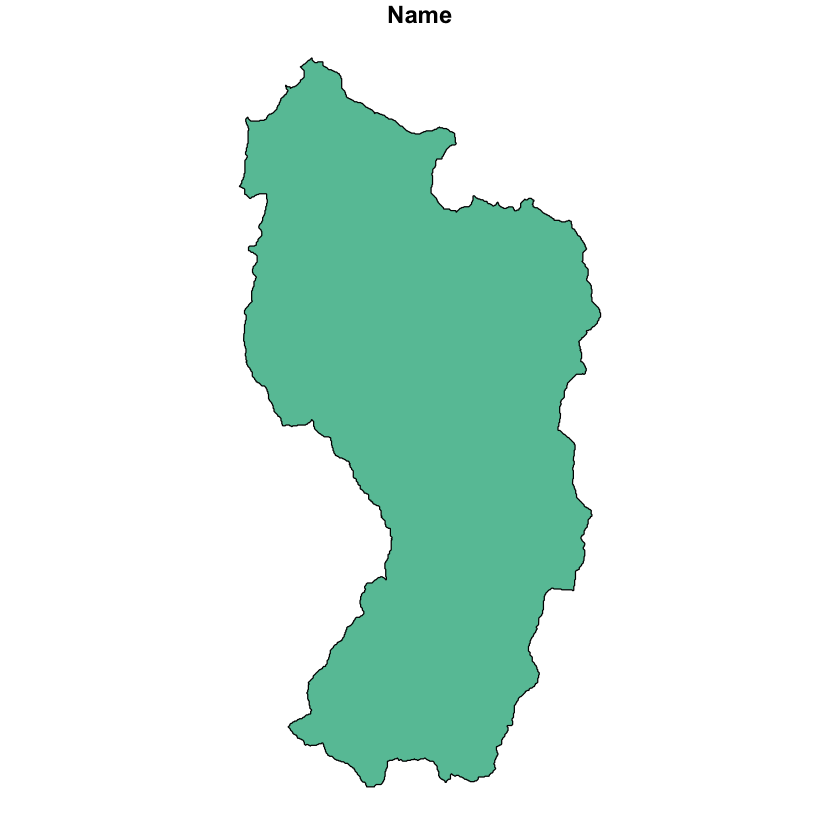

In [69]:
shp = st_read('Watershed_Boundary-line.geojson') %>% st_cast('POLYGON')
plot(shp[1])

### In the current directory, the NLDAS data are stored in the sub-directories:
"2001"
"2002"

### 3) set your directory

#### setwd('YOUR_LDAS_DATA_DIRECTORY')

In [84]:
## generate directory names
dirs = paste(c(2001:2019))

### 4) Extract NLDAS data (Paralell processing) 

In [77]:
## define number of cores used in paralell 
registerDoParallel(cores = 6)

## list all NLDAS files in the dirs
df_all = foreach(y = dirs, .combine = rbind)%do%{
            nldas_files =  list.files(path = y, pattern = '*.grb', full.names = TRUE) ## list all NLDAS file in this dir
            df_year = foreach(j = 1:length(nldas_files), .combine = rbind)%dopar%{ ## extract NLDAS for one year using this paralell loop
                nldas = raster::stack(nldas_files[j]) ## read an NLDAS GRIB file as raster stacked file
                names(nldas) = c('TMP', # Temperature [C]
                                'SPFH', # Specific humidity [kg/kg]
                                'PRES', # Pressure [Pa] 
                                'UGRD', # u-component of wind [m/s]
                                'VGRD', # v-component of wind [m/s]
                                'DLWRF', # Downward longwave radiation flux [W/m^2]
                                'CONVAPCP', # Cloud Mixing Ratio [kg/m^2]
                                'CAPE', # Convective available potential energy [J/kg]
                                'PEVAP', # Potential evaporation [kg/m^2]
                                'APCP', # Total precipitation [kg/m^2] = mm
                                'DSWRF' # Downward shortwave radiation flux [W/m^2]
                                )
                df1 = extract(nldas, shp, weights=T, normalizeWeights=F) %>% data.frame() ## extract NLDAS variables by a shp file, and area coverages
                df2 = df1[,-12] * df1[,12] ## multiply weights (column 12) to NLDAS variables, and get the dataframe summarize 
                df3 = df2 %>% summarise(TMP = mean(TMP), 
                                        SPFH = mean(SPFH),
                                        PRES = mean(PRES),
                                        UGRD = mean(UGRD),
                                        VGRD = mean(VGRD),
                                        WIND = mean(sqrt(UGRD^2 + VGRD^2)),
                                        DLWRF = mean(DLWRF),
                                        CONVAPCP = mean(CONVAPCP),
                                        PEVAP = mean(PEVAP),
                                        APCP_mean = mean(APCP),
                                        APCP_sum = sum(APCP),
                                        DSWRF = mean(DSWRF)
                                       )
                ## add date and time into data frame
                cbind.data.frame(
                                Year = substr(nldas_files[j], 24, 27),
                                Mnth = substr(nldas_files[j], 28, 29),
                                Day = substr(nldas_files[j], 30, 31), 
                                Hr = substr(nldas_files[j], 33, 34),
                                df3
                )

            }
    df_year
}


In [78]:
df_all

Year,Mnth,Day,Hr,TMP,SPFH,PRES,UGRD,VGRD,WIND,DLWRF,CONVAPCP,PEVAP,APCP_mean,APCP_sum,DSWRF
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2001,12,28,17,0.22454583,0.0011271303,23812.26,0.07189167,0.33440000,0.3420406,65.07058,0,0.0073336667,0.000000,0.000000,51.500498
2001,12,29,00,0.04702083,0.0009238197,23823.35,-0.50046667,0.31931250,0.5936559,58.64501,0,0.0033970417,0.000000,0.000000,3.741632
2001,12,29,01,-0.18031250,0.0009200055,23803.13,-0.37880000,0.40824167,0.5569118,58.64696,0,-0.0019761667,0.000000,0.000000,0.000000
2001,12,29,02,-0.40712083,0.0009161899,23783.03,-0.25617917,0.49787500,0.5599172,58.64860,0,-0.0019761667,0.000000,0.000000,0.000000
2001,12,29,03,-0.63375833,0.0009124036,23762.89,-0.13355833,0.58610833,0.6011329,58.75548,0,-0.0019761667,0.000000,0.000000,0.000000
2001,12,29,04,-0.69379583,0.0008875812,23774.46,-0.27447917,0.48054583,0.5534104,58.75563,0,-0.0015319167,0.000000,0.000000,0.000000
2001,12,29,05,-0.75223750,0.0008627650,23786.07,-0.41572500,0.37582083,0.5604182,58.75648,0,-0.0015319167,0.000000,0.000000,0.000000
2001,12,29,06,-0.81083750,0.0008379704,23797.69,-0.55711250,0.27025833,0.6192043,58.18393,0,-0.0015319167,0.000000,0.000000,0.000000
2001,12,29,07,-0.81195000,0.0008254263,23798.84,-0.47926250,0.23937917,0.5357191,58.18377,0,-0.0012759583,0.000000,0.000000,0.000000
